In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3


In [3]:
import warnings
warnings.filterwarnings('ignore')

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# replicate Meshal's pretty plotting colors
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

In [5]:
def repeat(f):
    d = {}
    for p, adata in adatas.items():
        d[p] = f(p, adata)
    return d

In [6]:
%%time
adatas = {
    f'patient_{p}': sc.read(f'/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_{p}.h5ad') for p in [1, 2, 3, 4]
}

CPU times: user 43.4 s, sys: 2.55 s, total: 45.9 s
Wall time: 46.2 s


Write this label in later:

In [7]:
import math
def f(p, adata):
    adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
    adata.obs['infected'] = adata.obs['infected'].astype('category')
    return adata[~adata.obs.infected.isna()]

adatas = repeat(f)

Distribution of viral counts in infected vs. uninfected samples, according to demultiplexed labels. This demonstrates that the infection and demultiplexing performed decently as cells labeled as infected have overall more virus than cells labeled as uninfected.

Trying to set attribute `.obs` of view, copying.


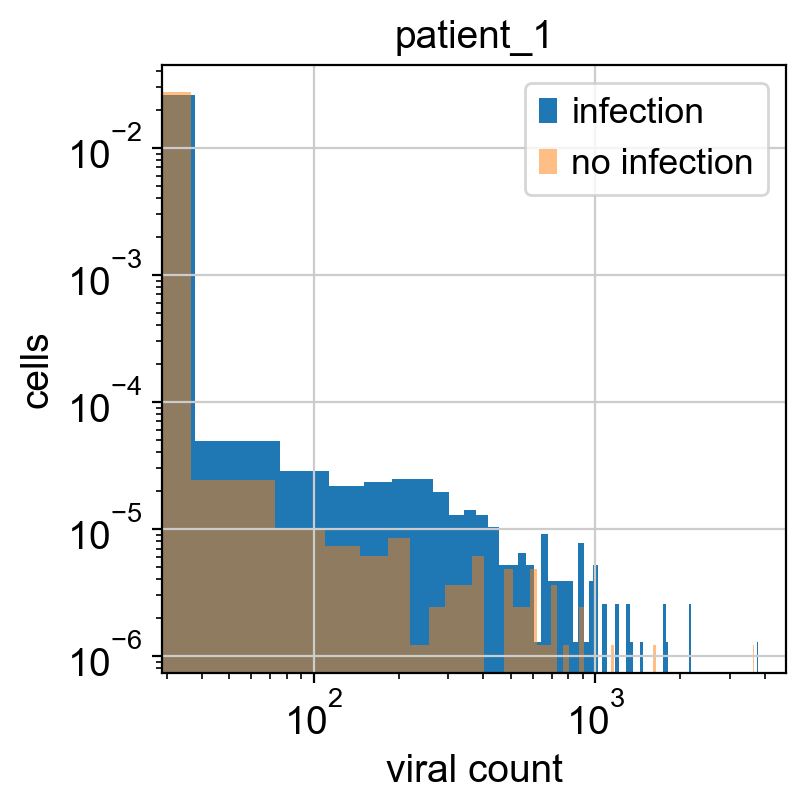

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


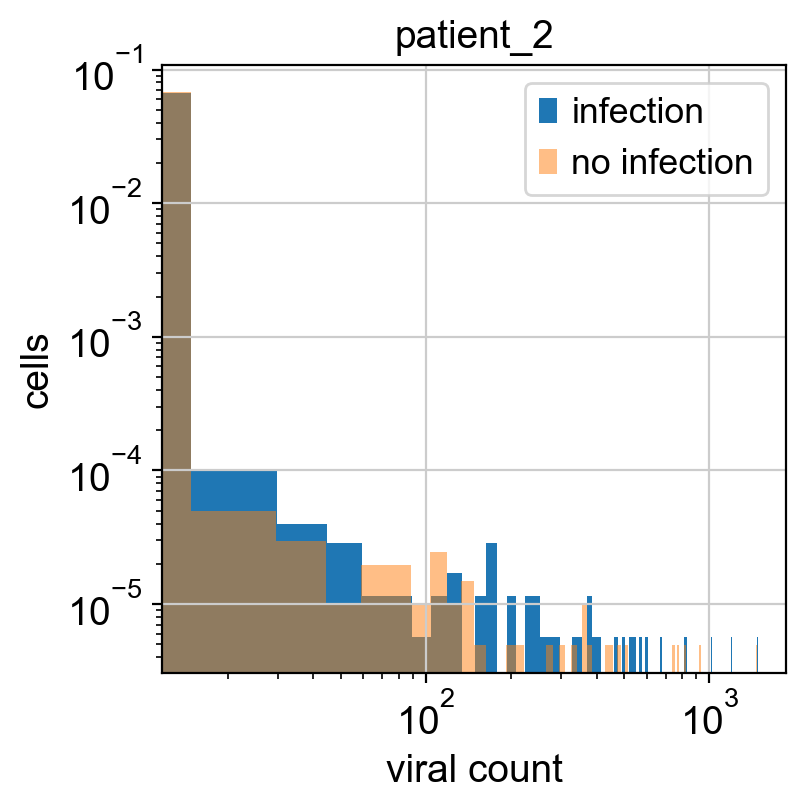

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


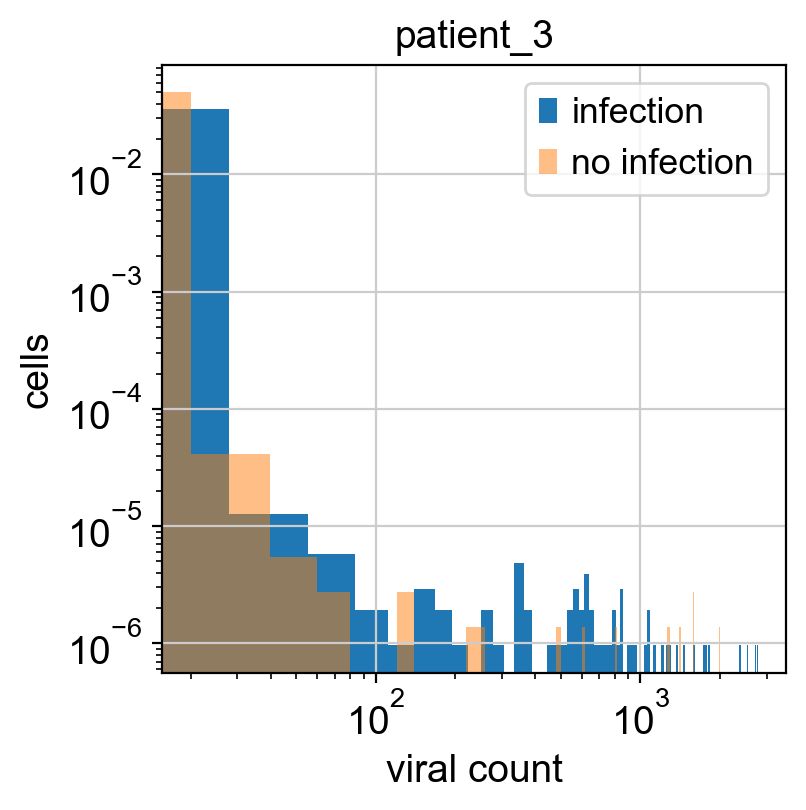

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


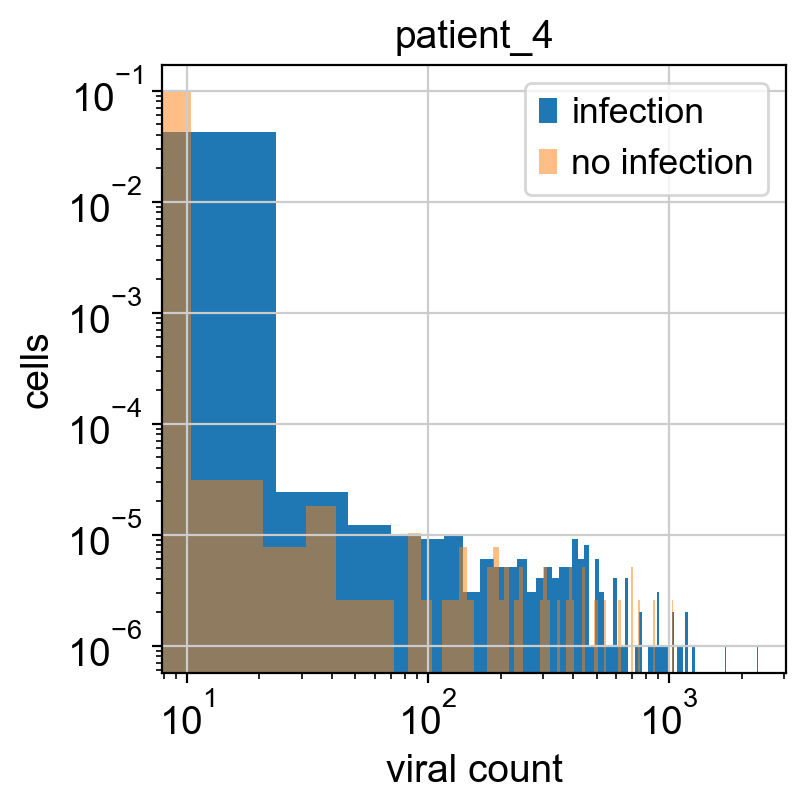

Background level: 2.0


{'patient_1': 427.9519999998447,
 'patient_2': 277.1000000000131,
 'patient_3': 23.305999999996857,
 'patient_4': 105.39999999993597}

In [8]:
import scipy as sp
def distr_plot(p, adata):
    adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
    inf_values = plt.hist(adata[adata.obs.infected == True].obs.viral_counts.values, bins=100, label='infection', density=True)
    no_inf = adata[adata.obs.infected == False].obs.viral_counts.values
    no_inf_values = plt.hist(no_inf, bins=100, alpha=.5, label='no infection', density=True)
    plt.xlabel('viral count')
    plt.ylabel('cells')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(p)
    plt.show()
    
    # Calculate a background level of viral count based on the average in the `no infection` samples.
    thresh = np.quantile(no_inf, .99)
    print('Background level:', thresh)
    
    return thresh
                 
bg_lvl = repeat(distr_plot)                 
bg_lvl_high = repeat(lambda p, adata: np.quantile(adata[adata.obs.infected == False].obs.viral_counts.values, .999))
bg_lvl_high

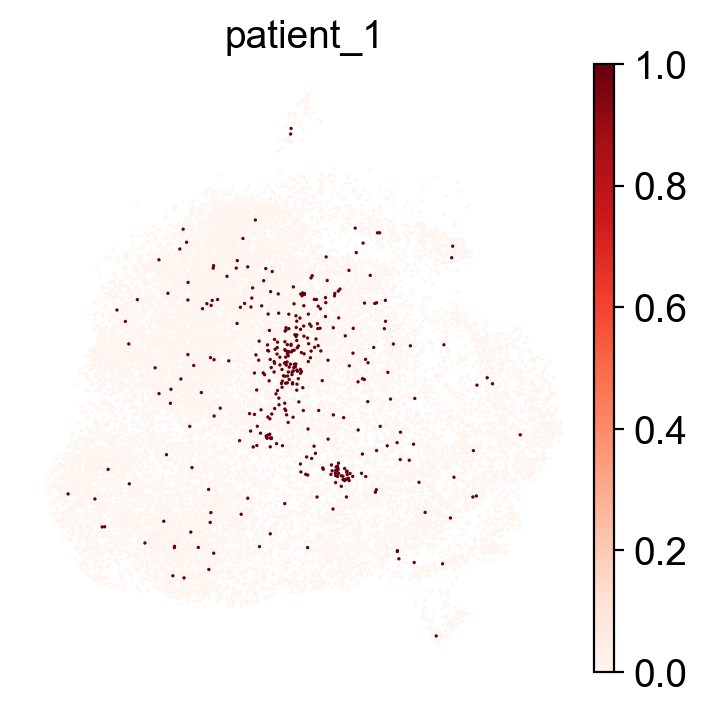

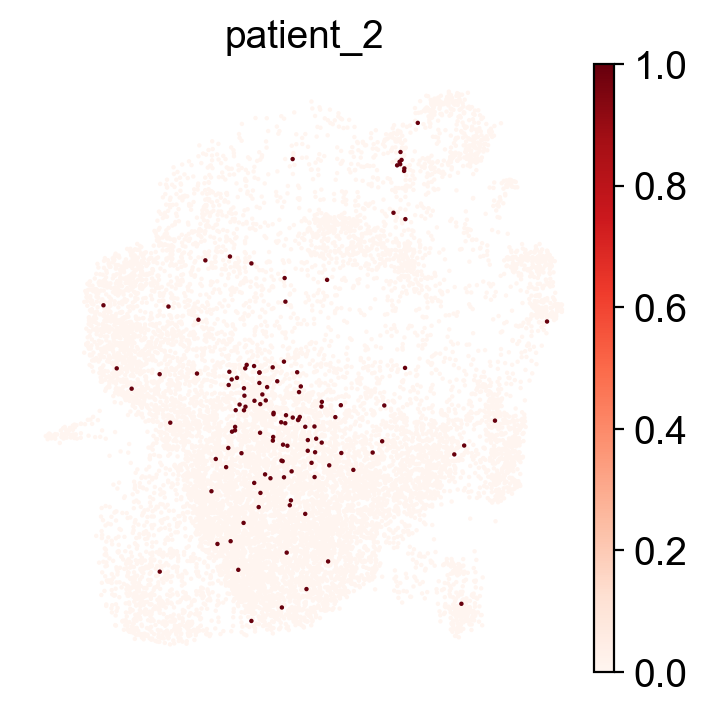

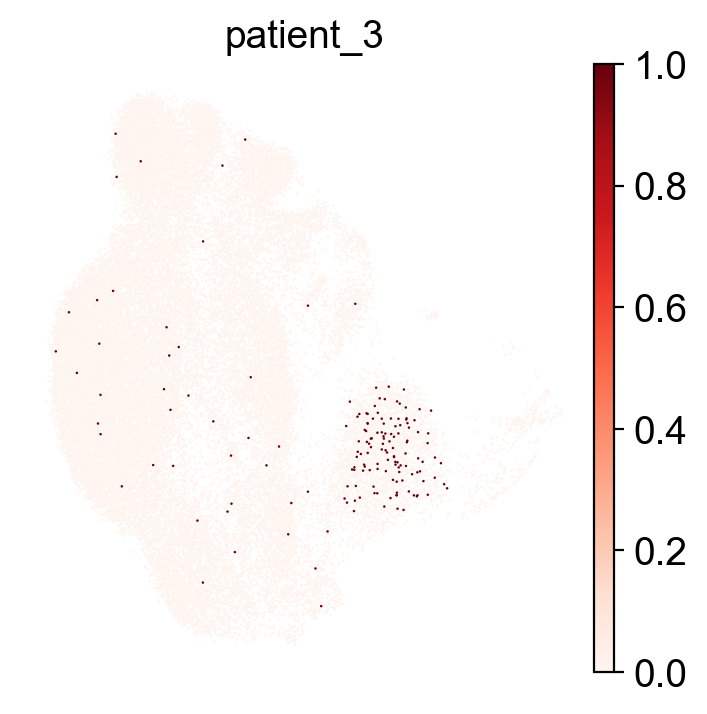

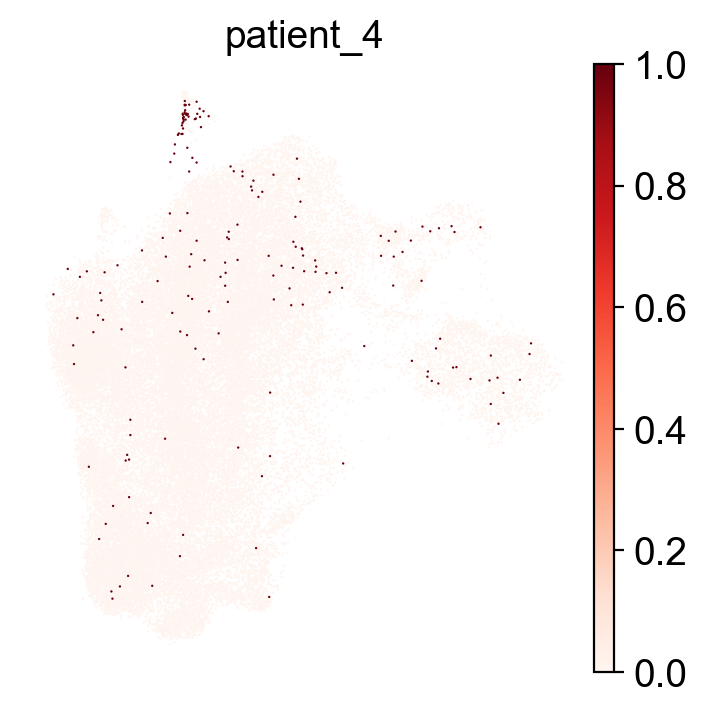

{'patient_1': None, 'patient_2': None, 'patient_3': None, 'patient_4': None}

In [9]:
def f(p, adata):
    adata.obs['infected_thresh'] = [x > bg_lvl[p] and x < bg_lvl_high[p] for x in adata.obs.viral_counts]
    sc.pl.umap(adata[adata.obs.infected], color='infected_thresh', palette='Reds', title=p)
    
repeat(f)

In [10]:
# convenience function for standard plotting
def plot(df):
    sns.barplot(
        data = df.T, orient='horizontal', ci = 'sd',
        capsize = 0.1, errwidth=.5, color='lightblue'
    )
    sns.stripplot(data = df.T, orient='horizontal', color='.3', size=4)

### % infected per treatment

In [11]:
def f(p, adata):
    d = {}
    for trt in adata.obs.treatment.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.treatment == trt)]
        d[trt] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

,patient_1,patient_2,patient_3,patient_4
TNFa_IFNg,0.010667,NaN,0.003288,0.008692
IFNa (b_d),0.008230,0.005199,0.009646,0.005138
IFNg,0.008779,0.005172,0.006534,0.004108
Tirapazamine,0.017408,0.009641,0.008889,0.008637
mock,0.017674,0.017407,0.009223,0.005436
IFNa_TNFa,0.014650,NaN,0.003276,0.006292
TNFa,0.057851,0.010949,0.006952,0.012377
Sorafenib,0.015558,NaN,0.004899,0.010018
TNFa_Tirapazamine,0.034465,NaN,0.006947,0.010271
TGFb2,0.022245,0.020803,0.009225,0.006973


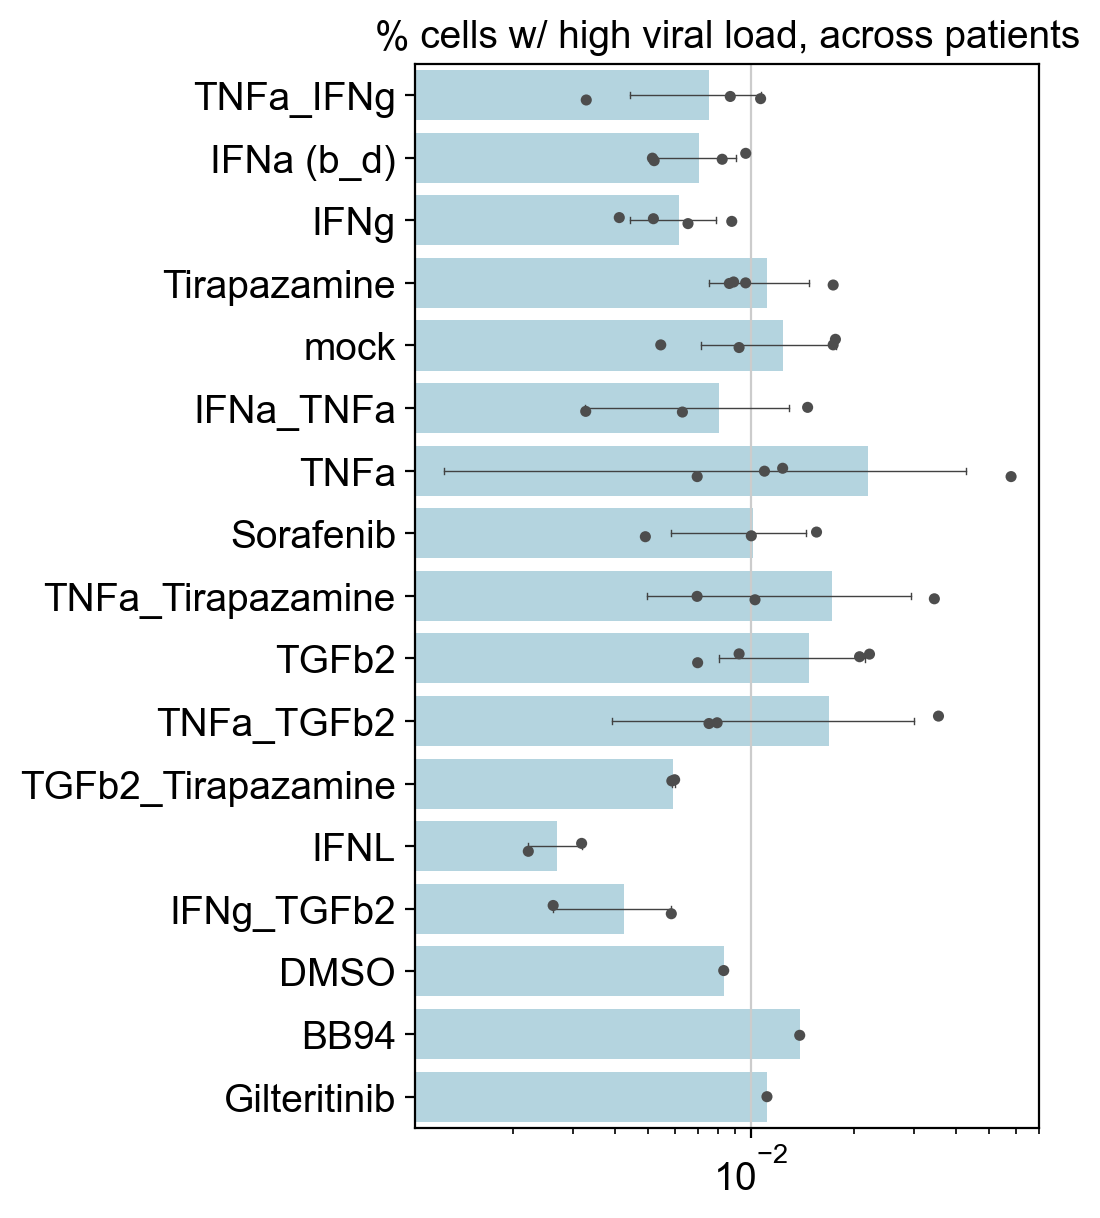

In [12]:
plt.figure(figsize=(4, 7))
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients');
# plt.grid(b=False)

### % infected per cell type

First, remove cells that are extremely infected and therefore don't exhibit any specific cell type:

In [13]:
adatas = repeat(lambda p, adata: adata[adata.obs.viral_counts < bg_lvl_high[p]])

In [14]:
# count per cell type
repeat(lambda p, adata: display(
    pd.crosstab(adata[adata.obs.treatment == 'mock'].obs.infected,
                adata[adata.obs.treatment == 'mock'].obs.cell_type)
))

cell_type,basal,ciliated,club,goblet,ionocytes
infected,,,,,
False,1003,8,2357,4,16
True,1431,19,2389,21,34


cell_type,basal,ciliated,club,goblet,ionocytes
infected,,,,,
False,1273,2,2080,30,7
True,718,13,886,37,10


cell_type,basal,ciliated,club,ionocytes
infected,,,,
False,3332,36,1109,8
True,4595,61,1477,28


cell_type,basal,ciliated,club,goblet,ionocytes
infected,,,,,
False,1635,140,1833,0,16
True,2147,194,2237,5,10


{'patient_1': None, 'patient_2': None, 'patient_3': None, 'patient_4': None}

Percent of cells per cell type in the virus treated sample (mock only) containing above-background levels of viral transcript, per replicate (patient).

In [15]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.cell_type == ct) & (adata.obs.treatment == 'mock')]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

,patient_1,patient_2,patient_3,patient_4
club,0.010465,0.022573,0.022343,0.003129
basal,0.008386,0.009749,0.001088,0.002329
ionocytes,0.029412,0.000000,0.000000,0.000000
ciliated,0.000000,0.000000,0.000000,0.010309
goblet,1.000000,0.000000,NaN,1.000000


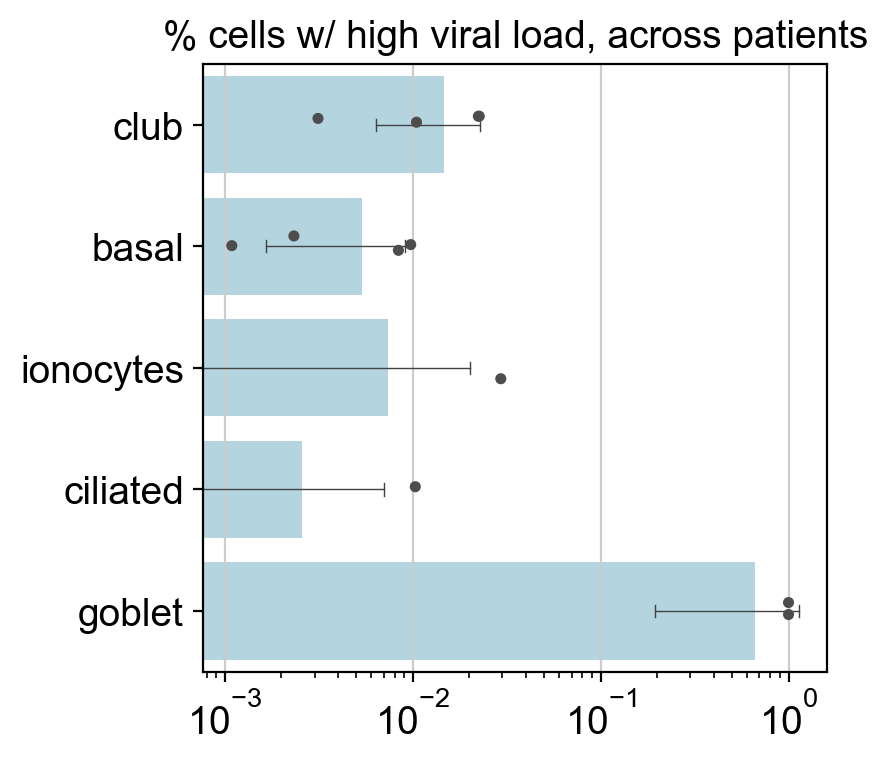

In [16]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients');
# plt.grid(b=False)

And as control:

In [17]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == False) & (adata.obs.cell_type == ct) & (adata.obs.treatment == 'mock')]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

,patient_1,patient_2,patient_3,patient_4
club,0.006364,0.007692,0.018034,0.001637
basal,0.004985,0.007855,0.001200,0.001223
ionocytes,0.000000,0.000000,0.000000,0.000000
ciliated,0.000000,0.000000,0.000000,0.007143
goblet,1.000000,0.000000,NaN,0.000000


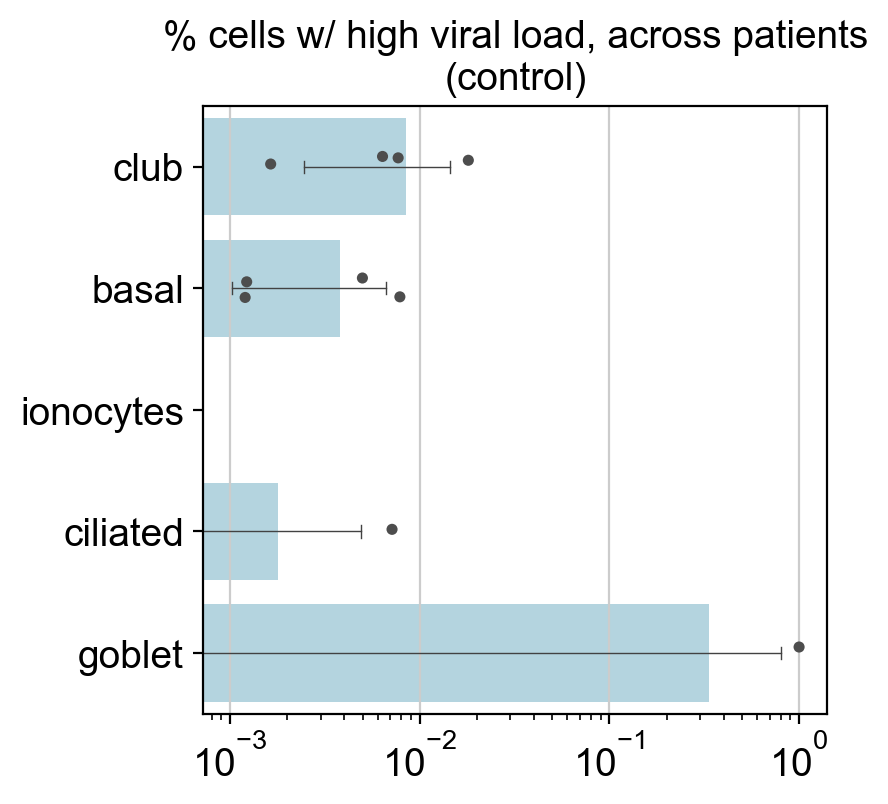

In [18]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients\n(control)');

With more samples (including all shared compounds so it's still comparable) - mostly as a sanity check since the counts for some cell types were extremely low. We can't make statements from this plot.

In [19]:
import anndata as ad
adata = ad.concat(adatas)
df = pd.crosstab(adata.obs.patient, adata.obs.treatment)
shared_cmpds = df.columns[df.all().values]

In [20]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.cell_type == ct) & (adata.obs.treatment.isin(shared_cmpds))]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

,patient_1,patient_2,patient_3,patient_4
club,0.013141,0.014043,0.017771,0.003971
basal,0.014016,0.008220,0.001304,0.001858
ionocytes,0.012500,0.000000,0.000000,0.000000
ciliated,0.000000,0.013699,0.000000,0.011111
goblet,1.000000,0.000000,NaN,1.000000


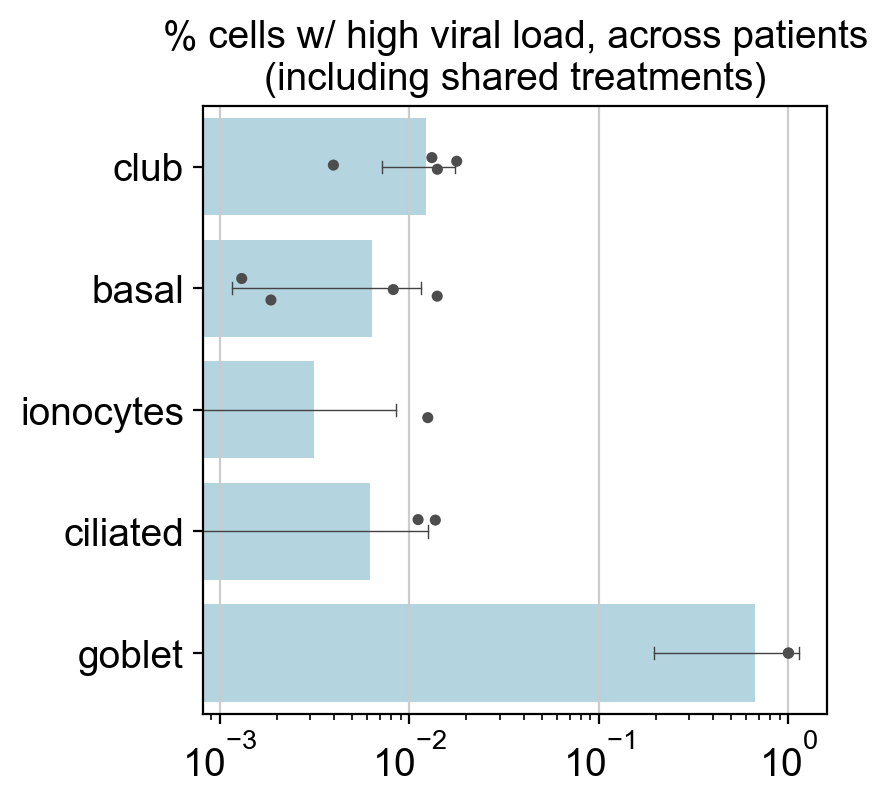

In [21]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients\n(including shared treatments)');